In [1]:
import torch
import numpy as np

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

ctx = torch.zeros([], device=device, dtype=dtype)

In [25]:
from bgmol.datasets import Ala2TSF300

target_energy = Ala2TSF300().get_energy_model(n_workers=1)

Using downloaded and verified file: /tmp/alanine-dipeptide-nowater.pdb


In [3]:
from simtk import openmm
with open('ala2_xml_system.txt') as f:
    xml = f.read()
system = openmm.XmlSerializer.deserialize(xml)

from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
from openmmtools import integrators
from simtk import unit
temperature = 300.0 * unit.kelvin
collision_rate = 1.0 / unit.picosecond
timestep = 4.0 * unit.femtosecond
integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
target_energy_xml_300 = OpenMMEnergy(66, energy_bridge)

In [19]:
from simtk import openmm
with open('ala2_xml_system.txt') as f:
    xml = f.read()
system = openmm.XmlSerializer.deserialize(xml)

from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
from openmmtools import integrators
from simtk import unit
temperature = 600.0 * unit.kelvin
collision_rate = 1.0 / unit.picosecond
timestep = 4.0 * unit.femtosecond
integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
target_energy_xml_600 = OpenMMEnergy(66, energy_bridge)

In [20]:
from simtk import openmm
with open('ala2_xml_system.txt') as f:
    xml = f.read()
system = openmm.XmlSerializer.deserialize(xml)

from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
from openmmtools import integrators
from simtk import unit
temperature = 1000.0 * unit.kelvin
collision_rate = 1.0 / unit.picosecond
timestep = 2.0 * unit.femtosecond
integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
target_energy_xml_1000 = OpenMMEnergy(66, energy_bridge)

In [56]:
from simtk import openmm
with open('ala2_xml_system.txt') as f:
    xml = f.read()
system = openmm.XmlSerializer.deserialize(xml)

from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
from openmmtools import integrators
from simtk import unit
temperature = 1500.0 * unit.kelvin
collision_rate = 1.0 / unit.picosecond
timestep = 1.0 * unit.femtosecond
integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
target_energy_xml_1500 = OpenMMEnergy(66, energy_bridge)

In [5]:
import mdtraj

TSF_MD = mdtraj.load('TSFtraj.dcd',top='ala2_fromURL.pdb', stride=100)
obc_300K_MD = mdtraj.load('300K.dcd', top = 'ala2_fromURL.pdb',stride=10)
#obc_600K_MD = mdtraj.load('600K.dcd', top = 'ala2_fromURL.pdb')
obc_1000K_MD = mdtraj.load('1000K.dcd', top = 'ala2_fromURL.pdb',stride=5)
obc_1500K_MD = mdtraj.load('1500K.dcd', top = 'ala2_fromURL.pdb',stride=20)
BGsamples_TSF = mdtraj.load('TSF_bgmolsystem_samplestraj.dcd', top='ala2_fromURL.pdb')
#TSF_samples_traj = mdtraj.load('TSF_stride35_samplestraj.dcd', top='ala2_fromURL.pdb')

In [9]:
def get_energies(trajectory, target_energy):
    coordinates = trajectory.xyz
    data = torch.tensor(coordinates.reshape(-1,66)).to(ctx)
    return target_energy.energy(data).cpu().detach().numpy()

In [4]:
import pickle
from simtk import openmm, unit
pickleFile = open('parameters300K.pkl','rb')
parametersdict = pickle.load(pickleFile)

In [23]:
def find_stride(fname):
    traj = mdtraj.load(f'{fname}.dcd',top='ala2_fromURL.pdb')
    print(traj.n_frames/10000)
    return traj.n_frames/10000

In [30]:
stride = find_stride('1000K')
traj = mdtraj.load('1000K.dcd',top='ala2_fromURL.pdb', stride=stride)
print(traj)

4.6796
<mdtraj.Trajectory with 11699 frames, 22 atoms, 3 residues, and unitcells>


In [49]:
def get_energies(fname):
    with open('ala2_xml_system.txt') as f:
        xml = f.read()
    system = openmm.XmlSerializer.deserialize(xml)

    from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
    from openmmtools import integrators
    from simtk import unit
    import pickle

    if 'BG' in fname or 'samples' in fname:
        temperature = 300.0 * unit.kelvin
        collision_rate = 1.0 / unit.picosecond
        timestep = 4.0 * unit.femtosecond
    else:
        pickleFile = open(f'parameters/parameters{fname}.pkl','rb')
        parametersdict = pickle.load(pickleFile)
        temperature = parametersdict['Temperature']
        collision_rate = parametersdict['Collision rate']
        timestep = parametersdict['Timestep']
    integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

    energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
    target_energy = OpenMMEnergy(66, energy_bridge)

    trajectory = mdtraj.load(f'{fname}.dcd',top='ala2_fromURL.pdb',stride=find_stride(fname))
    coordinates = trajectory.xyz
    data = torch.tensor(coordinates.reshape(-1,66)).to(ctx)
    return target_energy.energy(data).cpu().detach().numpy()

In [32]:
def average_energy(trajectory, target_energy):
    coordinates = trajectory.xyz
    data = torch.tensor(coordinates.reshape(-1,66)).to(ctx)
    energies = target_energy.energy(data).cpu().detach().numpy()
    return np.average(energies)

In [60]:
# def plot_energy(ax,
#         data_300,
#         #data_600,
#         data_1000,
#         data_1500,
#         #BGdata,
#         TSF):
    
#     obc_300_energies = get_energies(data_300, target_energy_xml_300)
#     #obc_600_energies = get_energies(data_600, target_energy_xml_600)
#     obc_1000_energies = get_energies(data_1000, target_energy_xml_1000)
#     obc_1500_energies = get_energies(data_1500, target_energy_xml_1500)
#     #BGTSF_energies = get_energies(BGdata, target_energy)
#     TSF_energies = get_energies(TSF, target_energy)
    
#     cut = max(np.percentile(BGTSF_energies, 95), 
#         np.percentile(TSF_energies,80),
        
#         20
#         )
    
#     ax.set_xlabel("Energy   [$k_B T$]")
#     # y-axis on the right
#     #ax2 = plt.twinx(ax)
#     #ax.get_yaxis().set_visible(False)
#     ax.hist(obc_300_energies,  bins=40, density=False, label="obc 300K",alpha=1)
#     #ax.hist(obc_600_energies,  bins=40, density=False, label="obc 600K",alpha=1)
#     ax.hist(obc_1000_energies,  bins=40, density=False, label="obc 1000K",alpha=1)
#     ax.hist(obc_1500_energies,  bins=40, density=False, label="obc 1500K",alpha=1)
#     #ax.hist(BGTSF_energies, bins=40, range=(-50 ,cut), density=False, label="BG",alpha=0.8)
#     ax.hist(TSF_energies, bins=40, density=False, label="TSF",alpha=0.6)


    # ax.set_ylabel(f"Count   [#Samples / {len(TSF_energies)}]")
    # ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')

In [70]:
def plot_energy(ax,
        *fnames):
    
    energies = {}
    for fname in fnames:
        energies[fname] = get_energies(fname)
        if np.percentile(energies[fname], 90) > 100:
            ax.hist(energies[fname],  bins=40, range=(-50,np.percentile(energies[fname], 90)), density=False, label=fname, alpha=(1-fnames.index(fname)/10))
        else:
            ax.hist(energies[fname],  bins=40, density=False, label=fname, alpha=(1-fnames.index(fname)/10))
    
    ax.set_xlabel("Energy   [$k_B T$]")
    ax.set_ylabel(f"Count   [#Samples / {len(energies[fnames[0]])}]")
    ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')

10.0
4.6796
20.0
3.7943
1.0


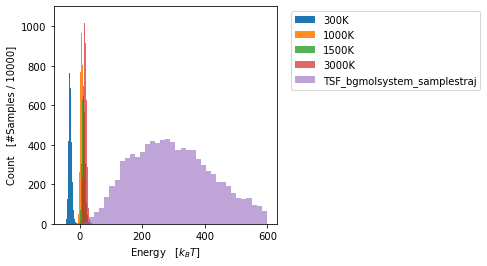

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))

plot_energy(ax, '300K', '1000K','1500K', '3000K','TSF_bgmolsystem_samplestraj')

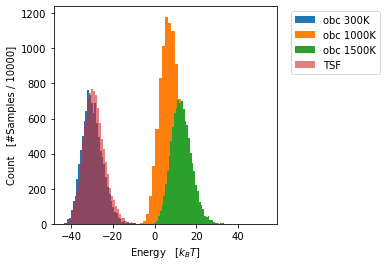

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))

#plot_energy_new(ax,'300K','TSFtraj')

plot_energy(ax, 
    #constrained_samples_traj,
    #my_samples_traj,
    obc_300K_MD,
    #obc_600K_MD,
    obc_1000K_MD,
    obc_1500K_MD,
    #BGsamples_TSF,
    #TSF_stride4_repeat4,
    #TSF_stride4_repeat5,
    #TSF_stride4_repeat6,
    #TSF_stride4_repeat7,
    #my_samplesfull_traj,
    #TSF_samples_traj,
    TSF_MD)
#plt.savefig('Repeatability/3repeatTSFstride4.png',bbox_inches='tight')
